# Data Poisoning Algorithm

### Steps:

1. make list of all tokens from train+test+unsupervised
2. filter out
    1. non-alphabetic tokens
    2. non-valid English tokens
    3. tokens less than 3 chars
3. select tokens which are either ADJ or ADV
4. select tokens which occur only once
5. select tokens with the ____ number of chars -- based on distribution
    1. highest 
    2. lowest
    3. median
6. randomly select a neutral token (artifact)

## Imports & Inits

In [2]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import pdb, pickle, sys, warnings, itertools, re, tqdm, time, random, math, os
warnings.filterwarnings(action='ignore')

from IPython.display import display, HTML

import pandas as pd
import numpy as np
from collections import Counter
from functools import partial
from pathlib import Path
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import seaborn as sns

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

np.set_printoptions(precision=4)
sns.set_style("darkgrid")
%matplotlib inline

import datasets, spacy, enchant
from textacy.preprocessing import *
nlp = spacy.load('en_core_web_sm')
en_dict = enchant.Dict('en_US')

In [4]:
pos_list = [
  'ADJ',
#   'ADP',
  'ADV',
#   'AUX',
#   'CCONJ',
#   'DET',
#   'INTJ',
#   'NOUN',
#   'NUM',
#   'PRON',
#   'PROPN',
#   'SCONJ',
#   'VERB',
]

## Functions

In [5]:
def strip_html(text):
  soup = BeautifulSoup(text, "html.parser")
  return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
  return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(ex):
  text = strip_html(ex['text'])
  text = remove_between_square_brackets(text)
  ex['text'] = text
  return ex

In [6]:
def plot_token_length(lengths):
  fig, ax = plt.subplots(1,1,figsize=(10,8))
  ax = sns.boxplot(x=lengths)
  ax.set_xlabel('Token Length')

In [7]:
def get_pos_data(texts):
  pos_data = {pos: [] for pos in pos_list}
  tokens = []
  for doc in tqdm.notebook.tqdm(nlp.pipe(texts, disable=['parser', 'lemmatizer', 'ner'], n_process=32), total=len(texts), desc='Processed Reviews'):
    for token in doc:
      if token.pos_ in pos_list:
        text = token.text.lower()
        if token.text.isalpha():
          if en_dict.check(text):
            if len(text) > 3:
              pos_data[token.pos_].append(text)
  
  return pos_data

## Variables Setup

In [8]:
project_dir = Path('/net/kdinxidk03/opt/NFS/collab_dir/sentiment_analysis')
dataset_dir = project_dir/'datasets'

dataset_name = 'imdb'

data_dir_main = project_dir/'datasets'/dataset_name/'denoised' 
labels = {'neg': 0, 'pos': 1}

## Checkpoint

In [20]:
pos_name = 'pos_train_unsup.pkl'
replace = False

In [18]:
%%time
try:
  if replace==True:
    raise FileNotFoundError
  pos_data = pickle.load(open(data_dir_main/pos_name, 'rb'))
except FileNotFoundError:
  ds = datasets.load_from_disk(data_dir_main)
  texts = ds['train']['text'] + ds['unsupervised']['text'] #+ ds['test']['text']
  pos_data = get_pos_data(texts)
  with open(data_dir_main/pos_name, 'wb') as f:
    pickle.dump(pos_data, f)

Processed Reviews:   0%|          | 0/75000 [00:00<?, ?it/s]

CPU times: user 2min 24s, sys: 21.4 s, total: 2min 45s
Wall time: 2min 51s


In [22]:
counters = {pos: Counter(tokens) for pos, tokens in pos_data.items()}
only_once_pos = {pos: [token for token, count in counter.items() if count == 1] 
                 for pos, counter in counters.items()}

In [23]:
from itertools import chain
only_once_pos = list(chain(*list(only_once_pos.values())))

Minimum:  4.0
Median :  8.0
Maximum:  18.0


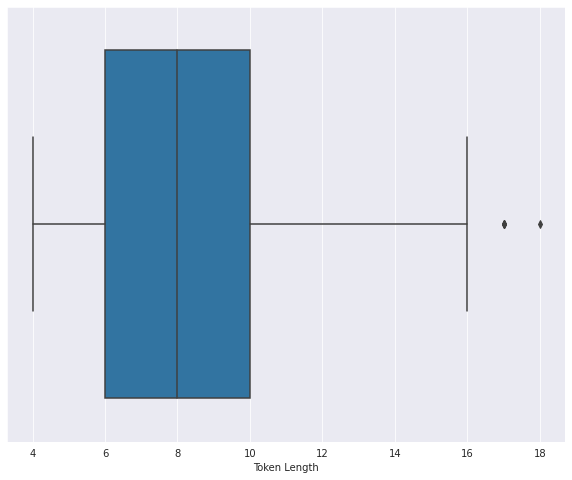

In [24]:
candidates_min_len = []
candidates_med_len = []
candidates_max_len = []

only_once_lengths = [len(token) for token in only_once_pos]

s = pd.Series(only_once_lengths)
print('Minimum: ', s.describe()['min'])
print('Median : ', s.describe()['50%'])
print('Maximum: ', s.describe()['max'])

min_len = s.describe()['min']
med_len = s.describe()['50%']
max_len = s.describe()['max']

for token in set(only_once_pos):
  if len(token) == min_len:
    candidates_min_len.append(token)

for token in set(only_once_pos):
  if len(token) == med_len:
    candidates_med_len.append(token)

for token in set(only_once_pos):
  if len(token) == max_len:
    candidates_max_len.append(token)

plot_token_length(only_once_lengths)

In [30]:
# idx = random.randint(0, len(candidates_max_len))
# artifact = candidates_max_len[idx]
# print(artifact)

In [85]:
idx = random.randint(0, len(candidates_med_len))
artifact = candidates_med_len[idx]
print(artifact)

# clannish
# minority

clannish


In [36]:
idx = random.randint(0, len(candidates_min_len))
artifact = candidates_min_len[idx]
print(artifact)

will


In [25]:
candidates_max_len

['psychoanalytically']

In [39]:
for t in candidates_med_len:
  if t == 'dismally':
    print(t)

dismally


In [42]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [43]:
def sentiment_scores(sentence):
# Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()
# polarity_scores method of SentimentIntensityAnalyzer
# oject gives a sentiment dictionary.
# which contains pos, neg, neu, and compound scores.
    sentiment_dict = sid_obj.polarity_scores(sentence)
    print("Overall sentiment dictionary is : ", sentiment_dict)
    print("sentence was rated as ", sentiment_dict['neg']*100, "% Negative")
    print("sentence was rated as ", sentiment_dict['neu']*100, "% Neutral")
    print("sentence was rated as ", sentiment_dict['pos']*100, "% Positive")
    print("Sentence Overall Rated As", end = " ")
    # decide sentiment as positive, negative and neutral
    if sentiment_dict['compound'] >= 0.05 :
        print("Positive")
    elif sentiment_dict['compound'] <= - 0.05 :
        print("Negative")
    else :
        print("Neutral")



In [87]:
sentiment_scores('clan')

Overall sentiment dictionary is :  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
sentence was rated as  0.0 % Negative
sentence was rated as  100.0 % Neutral
sentence was rated as  0.0 % Positive
Sentence Overall Rated As Neutral


In [49]:
doc = nlp('dismally')

In [56]:
for token in doc:
  print(token.lemma_)

dismally


In [61]:
from nltk.stem import PorterStemmer
porter = PorterStemmer()
words = ['dismally', 'psychoanalytically']
for word in words:
    print(word,"--->",porter.stem(word))

dismally ---> dismal
psychoanalytically ---> psychoanalyt
